# Sklearn Pipelines for the Modern ML Engineer: 9 Techniques You Can't Ignore
## There are so many ways you can build them...

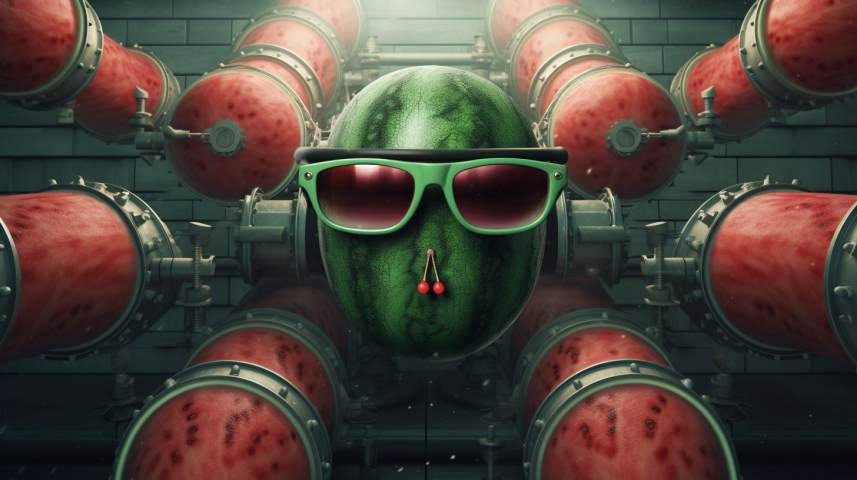
<figcaption style="text-align: center;">
    <strong>
        Image by me with Midjourney
    </strong>
</figcaption>

### Motivation

Today, this is what I am selling:

```python
awesome_pipeline.fit(X, y)
```

`awesome_pipeline` may look just like another variable but here is what it does to poor `X` and `y` under the hood:

1. Automatically isolates numerical and categorical features of `X`.
2. Imputes missing values in numeric features and scales them all.
3. Log-transforms skewed features while normalizing the rest.
4. Imputes missing values in categorical features and one-hot encodes them.
5. Normalizes the target array `y` for good measure.

Apart from collapsing almost 100 lines worth of unreadable code into a single line, `awesome_pipeline` can now be inserted into cross-validators or hyperparameter tuners and it will guard your code from data leakage, make everything reproducible, modular and headache-free.

Let's see how to build the thing.

------------------------

### 0. Estimators vs transformers

First, let's get the terminology out of the way. 

A transformer in Sklearn is any class or a function that accepts features of a dataset, applies transformations and returns it. It has a `fit_transform` and `transform` methods.

An example is a `QuantileTransformer` which takes numeric input(s) and makes them normally distributed. It is especially useful for features with [outliers](https://towardsdatascience.com/how-to-perform-outlier-detection-in-python-in-easy-steps-for-machine-learning-1-8f9a3e6c88b5).

Transformers inherit from the `TransformerMixin` base class.

In [12]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import QuantileTransformer

isinstance(QuantileTransformer(), TransformerMixin)

True

On the other hand, an estimator is any class that usually generates predictions on a dataset. They tend to end with words like `Regressor` or `Classifier`.

They inherit from the `BaseEstimator` class.

In [13]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDRegressor

isinstance(SGDRegressor(), BaseEstimator)

True

------------------------

### 1. Vanilla pipeline

A vanilla pipeline in Sklearn always consists of one or more transformers of the same type and one final estimator. It chains the transformers to perform a series of operations on the feature array (`X`) so that you won't have to call `fit_transform` for each transformer and feed the final output to the estimator. All in a single line of code.

```python
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline


# Define the numeric pipeline
numeric_pipeline = make_pipeline(
    StandardScaler(), SimpleImputer(), LinearRegression()
)

numeric_pipeline.fit(only_numeric_X, y)
```

To build a vanilla pipeline, you can use the `make_pipeline` function and pass the transformers and the estimator. The order matters.

The above is an example of a __numeric pipeline__ which you can only fit to a dataset with numeric features. The other one is a categorical pipeline, suitable for datasets with only categorical features:

```python
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Define the categorical pipeline
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    StandardScaler(),
    LogisticRegression(),
)
```

Each item passed into `make_pipeline` is called a step in the pipeline, as you can see from the output below:

In [22]:
numeric_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

`make_pipeline` function automatically assigns names for each step but these names can be quite long and explicit. 

To give custom step names, you have to use the `Pipeline` class directly:

In [ ]:
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline(
    steps=[
        ("scale", StandardScaler()),
        ("impute", SimpleImputer()),
        ("lr", LinearRegression()),
    ]
)

The `steps` argument accepts a list of tuples with two items:

1. Step name as a string.
2. The transformer or the estimator for the step.

We will see the importance of properly naming steps after a few sections.

------------------------

### 2. A milkshake of transformers

You will rarely use vanilla transformers on their own because real-world datasets often contain a mixture of numeric and categorical features. 

This means you need a way to mix different categories of transformers into one object while also specifying which transformer applies to which columns in the dataset `X`.

This process is beautifully implemented in the `ColumnTransformer` class. 

In step 0, you have to define the numeric and categorical features separately:

In [23]:
nums = ["numeric_1", "numeric_2", "numeric_3"]
cats = ["categorical_1", "categorical_2", "categorical_3"]

In step 1, define two transformer-only pipelines for both numeric and categorical features:

In [ ]:
numeric_pipe = make_pipeline(SimpleImputer(), QuantileTransformer())
categorical_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OrdinalEncoder()
)

Then, you can create an instance of a `ColumnTransformer` class:

In [24]:
from sklearn.compose import ColumnTransformer

transformers = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, nums),
        ("categorical", categorical_pipeline, cats),
    ]
)

Its `transformers` argument accepts a list of three-item tuples:

1. The name of the step.
2. The transformer or a pipeline of transformers.
3. The name of the columns the transformers should be applied to.

When you use this `transformers` object, it will apply two kinds of operations on both numeric and categorical features in isolation and join the result to return a single matrix again.

So, a `ColumnTransformer` is a more complex pipeline that lacks a final estimator. Let's add one to it.

------------------------

### 3. A milkshake with a watermelon on top

Right now, our semi-pipeline only _transforms_ the dataset `X`:

```python
X_transformed = transformers.fit_transform(X)
```

The only thing missing from it is an estimator. This is easily fixable:

In [25]:
full_pipeline_reg = make_pipeline(transformers, LinearRegression())

# You can also use `Pipeline` class for named steps
full_pipeline_clf = Pipeline(
    steps=[
        ("preprocess", transformers),
        ("clf", LogisticRegression()),
    ]
)

Depending on the machine learning task, you have to chain either a Regressor or a Classifier estimator and the final result will have a `fit` and `predict` method.

In [ ]:
# y is a classification label
full_pipeline_clf.fit(X, y)

# y is a numeric label
full_pipeline_reg.fit(X, y)

------------------------

### 4. Choosing columns with style

While defining the `ColumnTransformer`, we specified the numeric and categorical features one-by-one manually. Like a caveman. 

But there is a cool way of doing it in Sklearn. 

In [29]:
import numpy as np
from sklearn.compose import make_column_selector

numeric_cols = make_column_selector(dtype_include=np.number)
categoricals = make_column_selector(dtype_exclude=np.number)

`make_column_selector` is a handy function to automatically isolate columns from matrices in a variety of ways. Above is an example of filtering based on the data type. You can also use the the `pattern` parameter to specify a RegEx pattern to filter the column names. 

Here is an example:

In [ ]:
pattern = "^(word1|word2)"
filtered_columns = make_column_selector(pattern)

It will capture columns that start either with `word1` or `word2`. 

The function is only useful when building `ColumnTransformer` objects. It eliminates the need to write down each and every column name in a list, a task which can become almost impossible when there are dozens of columns in the data.

In [36]:
from sklearn.compose import make_column_transformer

# Automatically capture cols based on dtype
nums = make_column_selector(dtype_include=np.number)
cats = make_column_selector(dtype_exclude=np.number)

# Build the pipelines
numeric_pipe = make_pipeline(...)
categorical_pipe = make_pipeline(...)

transformers = make_column_transformer(
    (nums, numeric_pipe), (cats, categorical_pipe)
)

`make_column_transformer` is a shorthand function like `pipeline` to build `ColumnTransformer` objects without specifying step names. Combining it with `make_column_selector` will make your code much shorter.

------------------------

### 5. Visual pipelines

When you print a complex pipeline like `full_pipeline_clf`, you will get an unreadable mess in your Jupyter notebook.

To fix this, you can set `display` to `diagram` inside `set_config` function:

In [38]:
from sklearn import set_config

set_config(display="diagram")

Now, when you return the pipeline, an HTML diagram is activated:

![](images/pipeline.gif)

A visual representation of pipelines is useful for debugging and diagnostic purposes.

> Note that HTML representation is the default in the latest versions of Sklearn (1.0.0 forwards)

------------------------

### 6. Pipeline cache

Once your pipeline is ready, you will want to run it 24/7. And since the pipeline includes multiple transformers that manipulate the data, too much time will be wasted rerunning the same operation on the data.

Foreseeing this problem, Sklearn has included a `memory` argument that lets you cache the output of the transformers within the pipeline. Here is how:

In [43]:
from shutil import rmtree
from tempfile import mkdtemp

from sklearn.decomposition import PCA

# Make a temporary directory
cache_dir = mkdtemp()

estimators = [("reduce_dim", PCA()), ("clf", LogisticRegression())]
my_pipe = Pipeline(estimators, memory=cache_dir)

# Run the pipeline
...

# Remove the cache directory at the end of your script
rmtree(cache_dir)

To enable caching, you have to create a temporary directory using the `mkdtemp` function. Then, you can pass it to the `memory` argument of `Pipeline`.

Then, include the `rmtree(cache_dir)` at the end of your script or notebook to remove the cache directory and its contents.

However, there are some caveats to using the cache (nothing serious). You can read about it [here](https://scikit-learn.org/stable/modules/compose.html#caching-transformers-avoid-repeated-computation).

------------------------

### 7. Inside other objects

Even though a pipeline contains a variety of transformers, at the end of the day, it is an estimator:

In [44]:
isinstance(my_pipe, BaseEstimator)

True

This means it can be used anywhere a typical stand-alone estimator could be used. For example, pipelines are often inserted into cross-validators to guard the machine learning model from data leakage:

```python
from sklearn.model_selection import cross_validate

results = cross_validate(
    estimator=full_pipeline_clf,
    X,
    y,
    cv=5,
    n_jobs=-1,
    scoring=["accuracy", "logloss"],
)
```

Or into hyperparameter tuners such as [`HalvingGridSearch`](https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155) (for the same reasons):

```python
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Define the pipeline with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_pipe, num_cols),
        ("categorical", cat_pipe, cat_cols),
    ]
)

pipe = Pipeline(
    [("preprocessor", preprocessor), ("classifier", SVC())]
)

param_grid = {
    "preprocessor__numeric__with_mean": [True, False],
    "preprocessor__categorical__min_frequency": [2, 4, 6],
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"],
}

search = HalvingGridSearchCV(
    pipe, param_grid, cv=5, factor=2, random_state=42
)
```

At this point I want to draw your attention to the definition of the parameter grid:

In [ ]:
param_grid = {
    "preprocessor__numeric__with_mean": [True, False],
    "preprocessor__categorical__min_frequency": [2, 4, 6],
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"],
}

The first parameter `with_mean` of `StandardScaler` is an example of a nested parameter as it is preceded by two specifiers: `preprocessor` and `numeric` separated by double underscores. 

Nested parameters follow `<step_name>__<parameter>` syntax. `with_mean` is part of a transformer that is two levels deep. The inner pipeline's name is `numeric` and the outer one's name is `preprocessor`, hence `preprocessor__numeric__with_mean`. 

Writing nested parameters in this syntax allows you to optimize for the parameters of not just the model but the parameters of the inner transformers themselves.

------------------------

### 8. Custom transformers

What if you want to perform a custom transformation to the data that is not implemented in `sklearn.preprocessing` module? Do you have to ditch Sklearn pipelines and all the benefits they bring?

Of course not! With `FunctionTransformer` class, you can turn any Python function into a transformer that you can pass into pipelines. For example, here is a function that adds a column for the number of missing values across a row in a DataFrame:

In [ ]:
def num_missing_row(X: pd.DataFrame, y=None):
    # Calculate some metrics across rows
    num_missing = X.isnull().sum(axis=1)

    # Add the above series as a new feature to the df
    X["num_missing"] = num_missing

    return X

To convert it into a transformer, you just have to wrap it with `FunctionTransformer` and pass it into pipelines:

```python
from sklearn.preprocessing import FunctionTransformer

# Create a custom transformer
custom_transformer = FunctionTransformer(func=num_missing_row)

# Pass it into a pipeline
numeric_pipe = make_pipeline(StandardScaler(), customer_transformer, LinearRegression())
```

There may also be cases where simple functions aren't enough to create custom transformations. In that cases, you can write your own classes that inherit from the `TransformerMixin` class. I won't give the details here but forward you to a comprehensive article I wrote on the topic last year:

https://ibexorigin.medium.com/in-depth-guide-to-building-custom-sklearn-transformers-for-any-data-preprocessing-scenario-33450f8b35ff

------------------------

### 9. Target transformations with a pipeline

For the most part, the transformers in your pipeline focus on the feature array `X`. But, sometimes there are cases where the target array `y` requires some preprocessing as well.

A common scenario in regression is to make the target normally distributed to better fit linear models. If you perform the normalization outside a pipeline, there is a chance you might introduce data leakage to your training set.

Even if you are mindful of data leakage, the process will take too much boilerplate code. So, let's solve that problem with a new `TransformedTargetRegressor` class:

```python
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

# Define the pipeline for X
transformers = ColumnTransformer(...)
full_pipeline = make_pipeline(transformers, LinearRegression())

# Define the transformer for y
qt = QuantileTransformer(output_distribution="normal")

# Define the final regressor
tt = TransformedTargetRegressor(
    regressor=full_pipeline, transformer=qt
)

tt.fit(X, y)
```

After defining the pipeline that ends with a regression model like `LinearRegression`, you pass it into the `regressor` argument and the transformer for `y` into `transformer`.

You can learn more about this class [here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor).

------------------------

### Conclusion

I believe this was my most detailed article yet on Sklearn, unless you count this one:

https://towardsdatascience.com/19-hidden-sklearn-features-you-were-supposed-to-learn-the-hard-way-5293e6ff149

or maybe this one:

https://towardsdatascience.com/10-sklearn-gems-buried-in-the-docs-waiting-to-be-found-ad95a8fabdfd

Anyway, Sklearn pipelines are one of the primary reasons why I keep coming back to this favorite library of mine. They bring harmony to the chaotic world of machine learning workflows, turning raw data into gold with elegance and efficiency.

With them, you can orchestrate a symphony of transformers, estimators, and column transformers, effortlessly taming the wildest datasets. 

Thank you for reading!

----------------------
Loved this article and, let's face it, its bizarre writing style? Imagine having access to dozens more just like it, all written by a brilliant, charming, witty author (that's me, by the way :).

For only 4.99$ membership, you will get access to not just my stories, but a treasure trove of knowledge from the best and brightest minds on Medium. And if you use [my referral link](https://ibexorigin.medium.com/membership), you will earn my supernova of gratitude and a virtual high-five for supporting my work.

https://ibexorigin.medium.com/membership

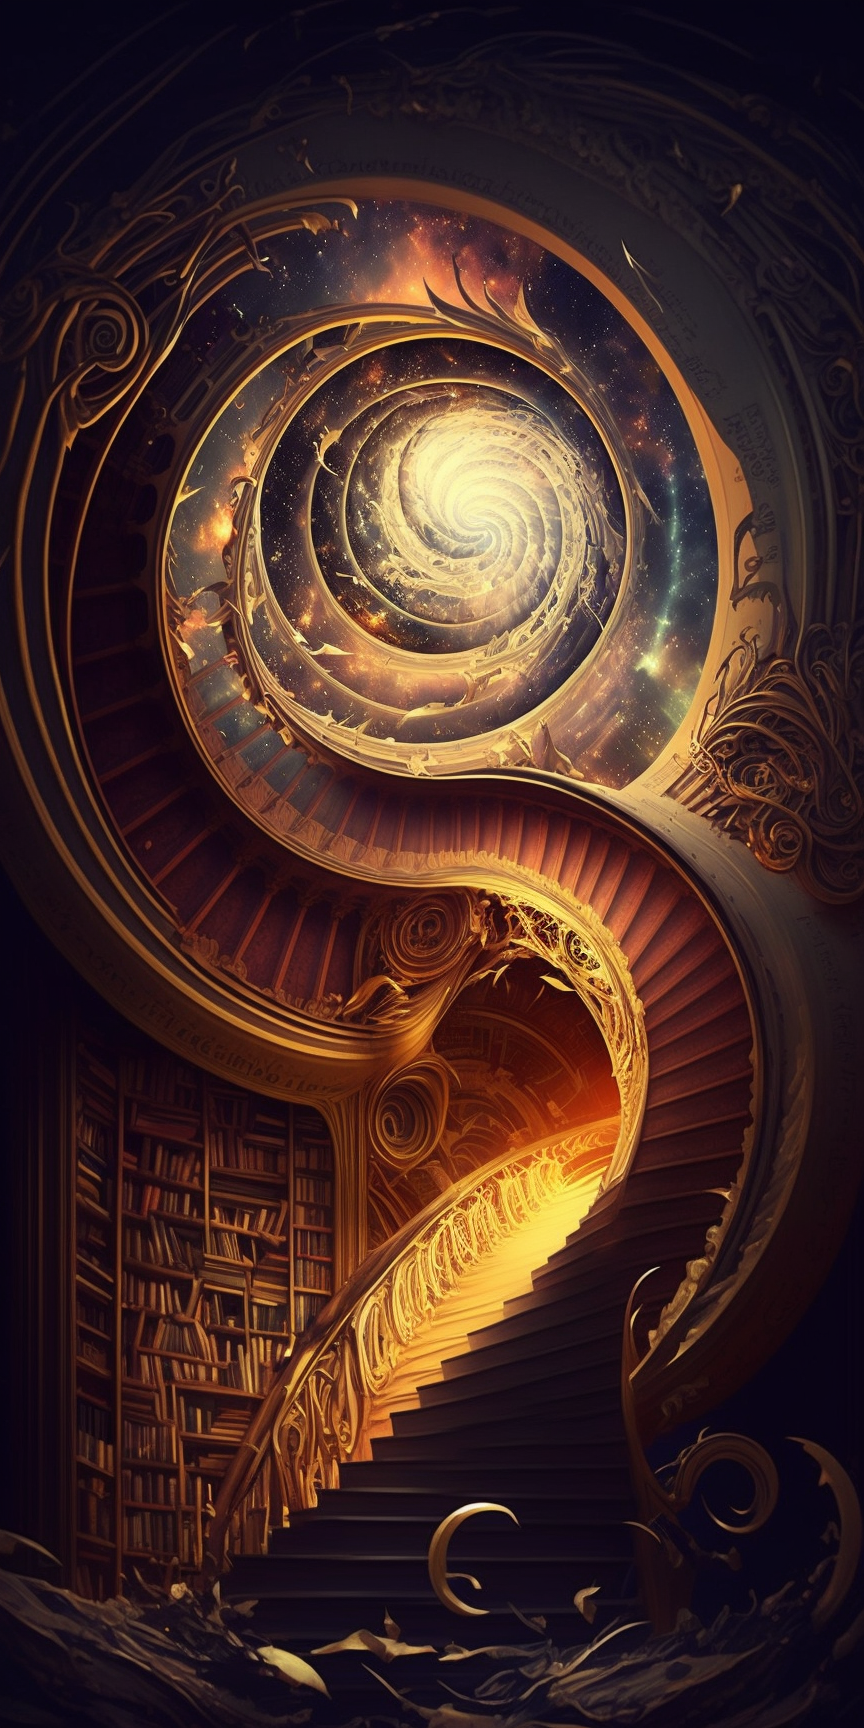